link : 
- PRIVATE - ASK DSF 

# Method:

1. Clean data - severity high or very high 
2. Claasify each disturbance typpe into on the 3 categories : 
    - 1 : Biotic-factor
    - 2 : Abiotic-factor
    - 3 : others 

In [1]:
#loading the data

import pandas as pd
df = pd.read_excel('/Users/arthurcalvi/Data/Disturbances_maps/Thierry Belouard & DSF/Veille_sanitaire/veille sanitaire DSF 2007_2023.xlsx', sheet_name='signalement0', header=2)

#convert to geopandas dataframe using lambert 93 coordinates
import geopandas as gpd
from shapely.geometry import Point

df['geometry'] = df.apply(lambda x: Point(x['Longitude'],x['Latitude']),axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})

columns = ["Année d'observation", "geometry", "Nom de commune saisie", "LIB_Département", 
           "LIB_Essence regroupée (ess. concernée)", "LIB_Feuillus/Résineux (ess. concernée)", 
            "Pourcentage de tiges atteintes", "Sévérité", 
             "LIB_Problème principal", "LIB_Type de problème", "Remarques"]

gdf = gdf[columns]


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Filtering on severity and causes

Keeping only severe and extremely severe events. 

The causes linked to mammals are not kept. 

In [2]:
gdf_filtered = gdf[gdf['Sévérité'] > 2]

In [3]:
gdf_filtered['LIB_Type de problème'].unique()

array(['Autre symptôme', "Dégât d'origine entomologique", nan,
       'Dégât dû à des végétaux', 'Dégât du à des mammifères',
       "Dégât d'origine abiotique", "Dégât d'origine pathologique",
       'Inconnu ou indéterminé', "Dégât d'origine sylvicole",
       'Dégât du à des grands mammifères', 'Dégât du à une pollution',
       "Dégât dû à d'autres animaux"], dtype=object)

In [4]:
gdf_filtered = gdf_filtered[ gdf_filtered['LIB_Type de problème'].isin(["Dégât d'origine entomologique", \
                                 "Dégât d'origine abiotique", "Dégât dû à des végétaux", \
                                    "Dégât d'origine pathologique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]) ]

In [5]:
gdf_filtered.shape

(32276, 11)

In [9]:
gdf_filtered.columns

Index(['Année d'observation', 'geometry', 'Nom de commune saisie',
       'LIB_Département', 'LIB_Essence regroupée (ess. concernée)',
       'LIB_Feuillus/Résineux (ess. concernée)',
       'Pourcentage de tiges atteintes', 'Sévérité', 'LIB_Problème principal',
       'LIB_Type de problème', 'Remarques'],
      dtype='object')

In [13]:
sum(['sécheresse' in  x.lower() for x in gdf_filtered['LIB_Problème principal'].unique().tolist() ])

1

In [14]:
gdf_filtered['LIB_Problème principal'].unique().tolist()

["Puceron vert de l'épicéa",
 'Tordeuse verte du chêne',
 'Typographe',
 'Gui',
 'Dégât entomologique indéterminé',
 'Carence en potassium',
 'Pissode du sapin',
 'Maladie des bandes rouges (échantillon de D. septospora)',
 'Dégât lié à la sécheresse',
 'Problème dû à un coup de chaleur',
 'Dégât abiotique indéterminé',
 'Bris de neige',
 'Maladie des bandes rouges (sur symptômes)',
 'Dégât dû à la foudre',
 'Dégât dû au vent',
 'Géométridé (espèce indéterminée)',
 'Tortricidé (espèce indéterminée)',
 'Sphaeropsis des pins (Diplodia sapinea)',
 'Pityokteines spp',
 'Rouille vésiculeuse pins 2aiguilles',
 'Fomes',
 'Lophyre roux',
 'Bombyx laineux',
 'Agrile du peuplier',
 'Dégât dû à la grêle',
 'Chancre du hêtre (N.ditissima)',
 'Armillaria mellea',
 'Scolytes (espèce indéterminée)',
 'Cryphale du sapin',
 'Coléophore du mélèze',
 'Cossus gâte bois',
 "Oïdium = 'blanc' du chene",
 'Pityokteines spinidens',
 'Basidiomycète (espèce indéterminée)',
 'Armillaire sur résineux',
 'Chermès d

## Classification

- Biotic-factors : "Dégât d'origine entomologique", "Dégât d'origine pathologique"
- Abiotic-factors : "Dégât d'origine abiotique", "Dégât d'origine sylvicole", "Dégât du à une pollution"
- Others : "Dégât dû à des végétaux"

In [15]:
def hl_class(x):
    if 'sécheresse' in x['LIB_Problème principal'].lower():
        return 'Drought-dieback'
    elif 'feu ' in x['LIB_Problème principal'].lower():
        return 'Fire'
    elif 'vent ' in x['LIB_Problème principal'].lower():
        return 'Storm'
    
    if x['LIB_Type de problème'] in ["Dégât d'origine entomologique", "Dégât d'origine pathologique", "Dégât dû à des végétaux"]:
        return 'Biotic'
    elif x['LIB_Type de problème'] in ["Dégât d'origine abiotique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]:
        return 'Other'
    else:
        return 'Other'

In [16]:
gdf_filtered['class'] = gdf_filtered.apply(hl_class, axis=1)

In [17]:
gdf_filtered.columns

Index(['Année d'observation', 'geometry', 'Nom de commune saisie',
       'LIB_Département', 'LIB_Essence regroupée (ess. concernée)',
       'LIB_Feuillus/Résineux (ess. concernée)',
       'Pourcentage de tiges atteintes', 'Sévérité', 'LIB_Problème principal',
       'LIB_Type de problème', 'Remarques', 'class'],
      dtype='object')

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


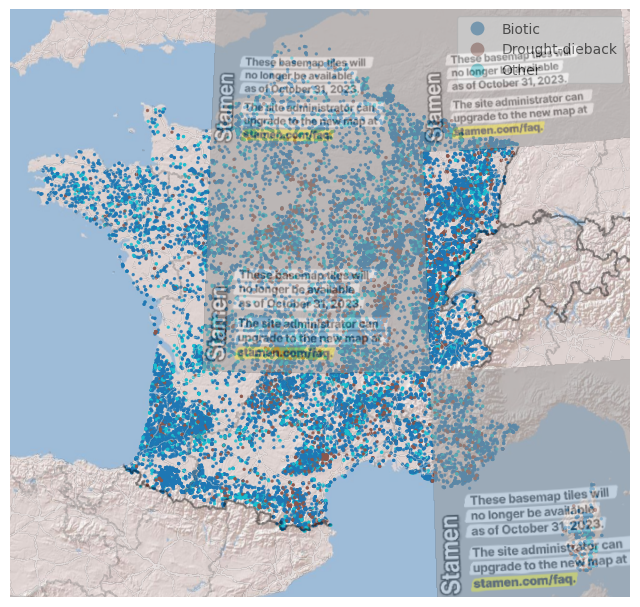

In [18]:
#custom cmap with [yellow, yellowbrown, light brown, red, dark bluegreen, grey]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

#color black in #

gplot = gdf_filtered.to_crs({'init': 'epsg:32631'})
import contextily as cx 
ax = gplot.plot(column='class', figsize=(8,8), legend=True, alpha=0.75, markersize=2)
ax.set_axis_off()
source = cx.providers.Esri.WorldShadedRelief
cx.add_basemap(ax, crs=gplot.crs, source=source, attribution=False)
#add tonelite map
cx.add_basemap(ax, crs=gplot.crs, zoom=6, source=cx.providers.Stamen.TonerLines, attribution=False, alpha=0.5)


In [17]:
ax.get_figure().savefig('../figures/classification_health-monitoring.png', dpi=200, bbox_inches='tight')

In [21]:
gdf_filtered["Année d'observation"].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023])

In [26]:
gdf_filtered.dtypes

Année d'observation                          int64
geometry                                  geometry
Nom de commune saisie                       object
LIB_Département                             object
LIB_Essence regroupée (ess. concernée)      object
LIB_Feuillus/Résineux (ess. concernée)      object
Pourcentage de tiges atteintes               int64
Sévérité                                     int64
LIB_Problème principal                      object
LIB_Type de problème                        object
Remarques                                   object
class                                       object
dtype: object

In [20]:
for col in ["Nom de commune saisie", "LIB_Département", "LIB_Essence regroupée (ess. concernée)",\
             "LIB_Feuillus/Résineux (ess. concernée)", "LIB_Problème principal", "LIB_Type de problème", \
                "Remarques", "class"]:
    gdf_filtered[col] = gdf_filtered[col].astype(str)

gdf_filtered.rename(columns={"Année d'observation": "year"},  inplace=True)
gdf_filtered.to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')

## Cleaning essence 

In [21]:
import geopandas as gpd

gdf = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')



In [22]:
gdf['LIB_Essence regroupée (ess. concernée)'].unique()

array(['Épicéas', 'Chênes', 'Sapins', 'Bouleaux', 'Pins', 'Douglas',
       'Charme', 'Autres feuillus', 'Fruitiers', 'Peupliers', 'Hêtre',
       'Mélèzes', 'Frênes', 'Cèdres', 'Tremble', 'Saules', 'Ormes',
       'Châtaignier', 'Érables', 'Arbustes', 'Aulnes', 'Noyers',
       'Autres résineux', 'nan', 'Taxodiacées', 'Tilleuls'], dtype=object)

In [23]:
import numpy as np

# Dictionary to hold translations
translation_dict = {
    'Épicéas': 'Spruces',
    'Chênes': 'Oaks',
    'Sapins': 'Firs',
    'Bouleaux': 'Birches',
    'Pins': 'Pines',
    'Douglas': 'Douglas',
    'Charme': 'Hornbeam',
    'Autres feuillus': 'Other Broadleaves',
    'Fruitiers': 'Fruit Trees',
    'Peupliers': 'Poplars',
    'Hêtre': 'Beech',
    'Mélèzes': 'Larches',
    'Frênes': 'Ash Trees',
    'Cèdres': 'Cedars',
    'Tremble': 'Aspen',
    'Saules': 'Willows',
    'Ormes': 'Elms',
    'Châtaignier': 'Chestnut',
    'Érables': 'Maples',
    'Arbustes': 'Shrubs',
    'Aulnes': 'Alders',
    'Noyers': 'Walnuts',
    'Autres résineux': 'Other Conifers',
    'nan': np.nan,  # Assuming 'nan' is kept as is
    'Taxodiacées': 'Taxodiaceae (a family of coniferous trees)',
    'Tilleuls': 'Lindens'
}


gdf['essence'] = gdf['LIB_Essence regroupée (ess. concernée)'].apply(lambda x: translation_dict[x])

In [24]:
gdf['LIB_Feuillus/Résineux (ess. concernée)'].unique()

def get_tree_type(x):
    if x == 'Conifère':
        return 'conifer'
    elif x == 'Feuillu':
        return 'broadleaf'
    else:
        return np.nan 
    
gdf['tree_type'] = gdf['LIB_Feuillus/Résineux (ess. concernée)'].apply(get_tree_type)

In [25]:
gdf[['year', 'geometry', 'LIB_Problème principal', 'Remarques', 'class', 'essence', 'tree_type']].to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')

# Simplified version

In [26]:
import geopandas as gpd
epsg = 'epsg:2154'
hm = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet').to_crs(epsg)

In [27]:
#hm
# def get_class(x):
#     if x  == 'biotic-factor':
#         return 'Biotic'
#     else :
#         return 'Other'
    
# hm['class'] = hm['class'].apply(get_class)
hm['year'] = hm['year'].astype(int)
hm.drop_duplicates(inplace=True)
hm.dropna(inplace=True)

hm.rename(columns={'LIB_Problème principal':'cause', 'Remarques':'notes'}, inplace=True)

In [28]:
hm

,year,geometry,cause,notes,class,essence,tree_type
10,2007,POINT (233924.714 6796466.646),Puceron vert de l'épicéa,Attaque de pucerons sévère sur l'ensemble du s...,Biotic,Spruces,conifer
17,2007,POINT (1026653.090 6351556.252),Tordeuse verte du chêne,nan,Biotic,Oaks,broadleaf
27,2007,POINT (698449.508 6534079.741),Typographe,proche suivi intensif attaque antérieure sur l...,Biotic,Spruces,conifer
36,2007,POINT (740742.263 6491948.064),Gui,"Sur les très gros bois, impact très fort Stati...",Biotic,Firs,conifer
40,2007,POINT (753262.733 6475917.867),Gui,Propriété Bachelerie Les sapins présentent une...,Biotic,Firs,conifer
...,...,...,...,...,...,...,...
73297,2023,POINT (662264.172 6253619.062),Dégât lié à la sécheresse,nan,Drought-dieback,Other Broadleaves,broadleaf
73298,2023,POINT (670287.917 6231398.863),Dégât lié à la sécheresse,nan,Drought-dieback,Other Broadleaves,broadleaf
73299,2023,POINT (478407.092 6345010.687),Sténographe,Futaie régulière de pin maritime 35-39 ans pré...,Biotic,Pines,conifer
73302,2023,POINT (984620.346 6324850.078),Mineuse des aiguilles du sapin,La mineuse c'est étendu a tous les sapins de c...,Biotic,Firs,conifer


In [ ]:
hm.to_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')